# Loading Libraries

In [735]:
#Nltk

import nltk 
from nltk import corpus
import nltk.corpus as Corpus
from nltk.corpus import stopwords 
nltk.download('stopwords') 

#sklearn
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict

#pandas
import pandas as pd 
from pandas_profiling import ProfileReport

#numpy
import numpy as np 

#graphical 
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/begosfriiive/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# The data set

The data set is divided into two folders: Train & Test, in which train has 5 columns and Test 4 columns since it does not include the target. Additionally there is an example of submission document for the competition. 

In [736]:
dtrain = pd.read_csv('train.csv')
dtest = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [737]:
print(dtrain.columns)
print(dtest.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [738]:
dtrain.shape

(7613, 5)

In [739]:
dtest.shape

(3263, 4)

# Problem description and goal 

The goal is to try to help the prediction of which Tweets are talking about real disasters and which ones are not. The problem is dealing with a binary classification problem classifying them 
The data set is of 10K tweets that were hand classified, from the company figure-eight and originally shared on their "Data For Everyone" website here.

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

##  Features description 
For this exercise building the features would be a good practice since we have the id,keyword, location, text and the variable target that is the classifier. 

Since there are few features and text is the most relevant one, I will have to build some features based on it, thus allowing me to run the model later on. 

#  EDA

First I started to learn if there are any null values and in which columns are they located. 

In [740]:
null_columns=dtrain.columns[dtrain.isnull().any()]
dtrain[null_columns].isnull().sum()

keyword       61
location    2533
dtype: int64

In [741]:
null_columns=dtest.columns[dtest.isnull().any()]
dtest[null_columns].isnull().sum()

keyword       26
location    1105
dtype: int64

There are two columns that have "NA" values, I should deal with them further on.

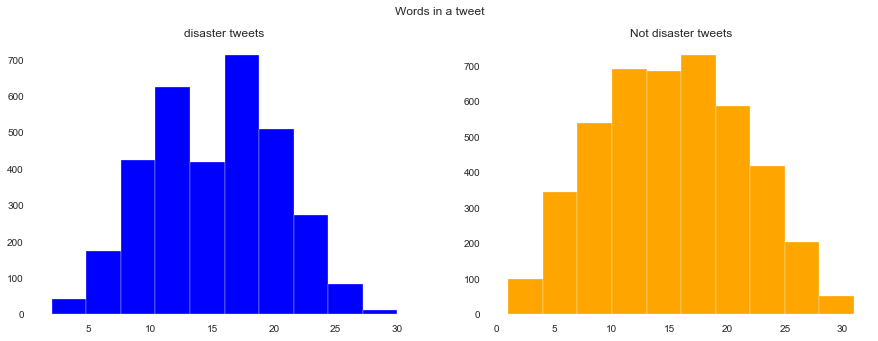

In [742]:
#Word Distribution according to the text: 

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
Text_len=dtrain[dtrain['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(Text_len,color='Blue')
ax1.set_title('disaster tweets')
Text_len=dtrain[dtrain['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(Text_len,color='orange')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

As seen in the graphs "non disaster" tweets have a higher length of words than "disaster" tweets, I will analyze this further in the preprocessing stage.

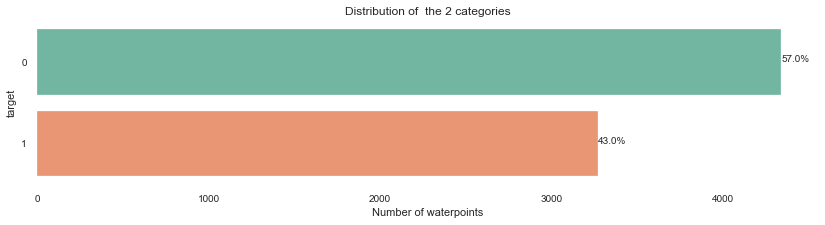

In [743]:
plt.figure(figsize=(14,3))
ax = sns.countplot(y="target", data=dtrain,palette='Set2')
plt.title('Distribution of  the 2 categories')
plt.xlabel('Number of waterpoints')
total = len(dtrain['target'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

By analyzing the target I can observe that is not an inbalanced dataset.

# Baseline

For building the baseline, I used Count Vectorizer  in order to run the model, I need to convert the text files into numerical features.

Count Vectorizer, similar to One-Hot encoding, segments the text feature into words, which are split by "space" and count the number of times the word appears, finally it assign an ID. 



In [744]:
#Doing the count Vectorizer in the "text" column

count_vect = CountVectorizer()
X_Total_counts = count_vect.fit_transform(dtrain['text'])

#To check how many rows I still have
X_Total_counts.shape

(7613, 21637)

In [745]:
clf = MultinomialNB(alpha=.01)
clf.fit(X_Total_counts, dtrain['target'])

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [746]:
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('clf', MultinomialNB()),
])
text_clf = text_clf.fit(dtrain['text'], dtrain['target'])
y_pred = text_clf.predict(dtest['text'])

Due to counter vector giving longer documents I used TF- IDF, which does not only represent if the words are there or not, instead represent the frequency and their inverse document frequency, thus giving less significance to the words that are frequent but appear everywhere, and gives higher value to the words that appears frequently but only in few places. 

In [747]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_Total_counts)
X_train_tfidf.shape

(7613, 21637)

In [748]:
clf = MultinomialNB().fit(X_train_tfidf, dtrain['target'])
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
])
text_clf1 = text_clf.fit(dtrain['text'], dtrain['target'])
y_pred = text_clf.predict(dtest['text'])


In [749]:
X = dtrain["text"]
y = dtrain["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
score=cross_val_score(text_clf1, X_train, y_train, cv=5).mean()
print(score)

0.793431855500821


In [432]:
predictions = text_clf.predict(dtest['text'])
ids = pd.read_csv("test.csv").id
datadriven = pd.DataFrame({'id': ids, "target": predictions})
datadriven.to_csv('base.csv', index=False)

By mixing both the score is the baseline taking into account the count vector and the frequency with the weight of frequent words. 

# Pre Processing Data

As seen in class pre processing the data is quite important, in this section I start with pre processing the data:

## Stop words

I started by defining the stopwords according to the target, thus concluding if all of them have to be eliminated or not.

In [750]:
import nltk.corpus as Corpus
from nltk import corpus
from nltk.corpus import stopwords
from collections import defaultdict

In [751]:
def create_corpus(target):
    corpus=[]
    
    for x in dtrain[dtrain['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [752]:
def create_corpus_df(dtrain, target):
    corpus=[]
    
    for x in dtran[dtrain['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [753]:
corpus=create_corpus(0)
stop = set(stopwords.words('english'))
dic=defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word]+=1
        
Stopwords_0=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
Stopwords_0

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442)]

In [754]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

Stopwords_1=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
Stopwords_1

[('the', 1051),
 ('in', 1037),
 ('of', 888),
 ('a', 730),
 ('to', 706),
 ('and', 462),
 ('on', 386),
 ('for', 368),
 ('is', 302),
 ('at', 273)]

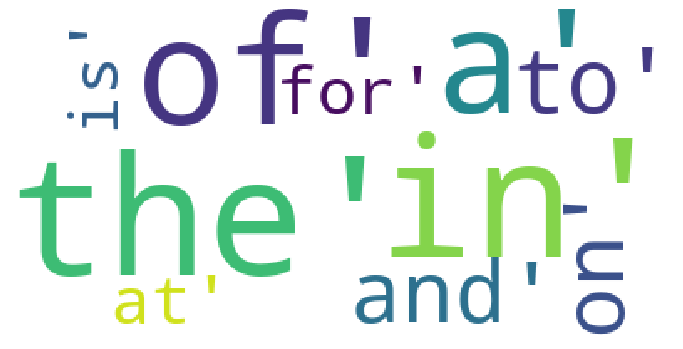

In [755]:
#Generating the wordcloud of Stopwords in target 1 (Disaster Tweets)

plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 100
                         ).generate(" ".join(str(v) for v in Stopwords_1))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

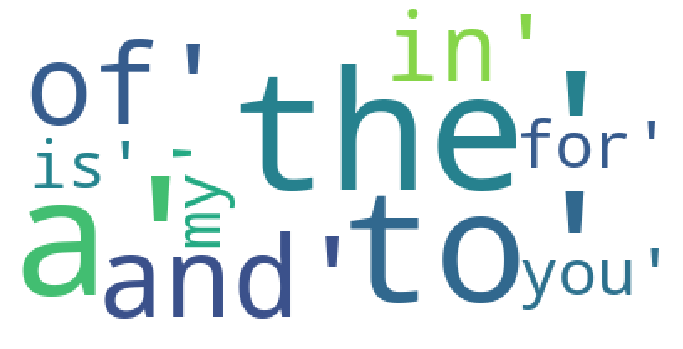

In [756]:
#Generating the wordcloud of Stopwords in target 0 - (Non Disaster Tweets)

plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                         background_color='white',
                         max_font_size = 100
                         ).generate(" ".join(str(v) for v in Stopwords_0))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Since "Stop words" are almost the same per target, just variating the number of occurrences, I decided to eliminate all stopwords, from the english language. 

In [757]:
#Removing Stopwords
count_vect = CountVectorizer(stop_words='english',ngram_range=(1, 3))
X_Total_counts = count_vect.fit_transform(dtrain['text'])

clf = MultinomialNB().fit(X_train_tfidf, dtrain['target'])

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english',ngram_range=(1, 3))),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
])

text_clf1 = text_clf.fit(dtrain['text'], dtrain['target'])
y_pred = text_clf.predict(dtest['text'])




In [758]:
X = dtrain["text"]
y = dtrain["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


score=cross_val_score(text_clf1, X_train, y_train, cv=5).mean()


print(score)


0.7963875205254516


In [348]:
predictions = text_clf.predict(dtest['text'])
ids = pd.read_csv("test.csv").id
datadriven = pd.DataFrame({'id': ids, "target": predictions})
datadriven.to_csv('stopwords.csv', index=False)

## Removing Punctuation/URL/HTML

In [918]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [919]:
top_tweet_bigrams=get_top_tweet_bigrams(dtrain['text'])[:10]
top_tweet_bigrams

[('the', 3266),
 ('in', 1979),
 ('to', 1946),
 ('of', 1828),
 ('and', 1420),
 ('is', 944),
 ('for', 892),
 ('on', 854),
 ('you', 806),
 ('my', 677)]

In [759]:
import re
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)



In [760]:
dtrain['text']=dtrain['text'].apply(lambda x : remove_url(x))

In [920]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


In [921]:
dtrain['text']=dtrain['text'].apply(lambda x :remove_html(x))

In [922]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="@disaster"
print(remove_punct(example))

disaster


In [923]:
dtrain["text"][2]

'All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected'

In [924]:
dtrain['text']=dtrain['text'].apply(lambda x : remove_punct(x))

In [925]:
#Removing HTML,PUNCTUATION

count_vect = CountVectorizer(stop_words='english',ngram_range=(1, 3))

X_Total_counts = count_vect.fit_transform(dtrain['text'])

clf = MultinomialNB().fit(X_train_tfidf, dtrain['target'])

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english',ngram_range=(1, 3))),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
])

text_clf = text_clf.fit(dtrain['text'], dtrain['target'])
y_pred = text_clf.predict(dtest['text'])


In [926]:
X = dtrain["text"]
y = dtrain["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


score=cross_val_score(text_clf1, X_train, y_train, cv=5).mean()
print(score)


0.7958949096880132


By removing the punctuation the score improved in the competition to .80, I am trying tokenization without punctuation and Url.

In [365]:
predictions = text_clf.predict(dtest['text'])
ids = pd.read_csv("test.csv").id
datadriven = pd.DataFrame({'id': ids, "target": predictions})
datadriven.to_csv('punctuation3.csv', index=False)

# Lemmatization

In [772]:
from nltk.stem import WordNetLemmatizer 
lmtzr = WordNetLemmatizer()
dtrain['words_lem']=dtrain['text'].apply(lambda x:' '.join([lmtzr.lemmatize(word,'v')for word in x.split()]))
print(dtrain['words_lem'])

0       Our Deeds be the Reason of this earthquake May...
1                   Forest fire near La Ronge Sask Canada
2       All residents ask to shelter in place be be no...
3       13000 people receive wildfires evacuation orde...
4       Just get send this photo from Ruby Alaska as s...
                              ...                        
7608    Two giant crane hold a bridge collapse into ne...
7609    ariaahrary TheTawniest The out of control wild...
7610    M194 0104 UTC5km S of Volcano Hawaii httptcozD...
7611    Police investigate after an ebike collide with...
7612    The Latest More Homes Razed by Northern Califo...
Name: words_lem, Length: 7613, dtype: object


In [773]:
from nltk.stem import WordNetLemmatizer 
lmtzr = WordNetLemmatizer()
dtest['words_lem']=dtest['text'].apply(lambda x:' '.join([lmtzr.lemmatize(word,'v')for word in x.split()]))
print(dtrain['words_lem'])

0       Our Deeds be the Reason of this earthquake May...
1                   Forest fire near La Ronge Sask Canada
2       All residents ask to shelter in place be be no...
3       13000 people receive wildfires evacuation orde...
4       Just get send this photo from Ruby Alaska as s...
                              ...                        
7608    Two giant crane hold a bridge collapse into ne...
7609    ariaahrary TheTawniest The out of control wild...
7610    M194 0104 UTC5km S of Volcano Hawaii httptcozD...
7611    Police investigate after an ebike collide with...
7612    The Latest More Homes Razed by Northern Califo...
Name: words_lem, Length: 7613, dtype: object


In [774]:
#Doing the count Vectorizer in the "text" column
#Doing the count Vectorizer in the "text" column

count_vect = CountVectorizer(stop_words='english',ngram_range=(1, 3))

Y_Total_counts = count_vect.fit_transform(dtrain['words_lem'])

clf = MultinomialNB(alpha=.01)
clf.fit(Y_Total_counts, dtrain['target'])
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(Y_Total_counts)

clf = MultinomialNB()
X = dtrain['words_lem']
y = dtrain["target"]


text_clf = Pipeline([('vect', CountVectorizer(stop_words='english',ngram_range=(1, 3))),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
])
text_clf1 = text_clf.fit(dtrain['words_lem'], dtrain['target'])
y_pred = text_clf.predict(dtest['words_lem'])



In [775]:
X = dtrain['words_lem']
y = dtrain["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


score=cross_val_score(text_clf1, X_train, y_train, cv=5).mean()


print(score)


0.7935960591133004


In [265]:
predictions = text_clf.predict(dtest['words_lem'])
ids = pd.read_csv("test.csv").id
datadriven = pd.DataFrame({'id': ids, "target": predictions})
datadriven.to_csv('lem.csv', index=False)

# Stemming

In [395]:
from nltk.stem.porter import *
ps=PorterStemmer()
dtrain['words_stem']=dtrain['text'].apply(lambda x:' '.join([ps.stem(word)for word in x.split()]))
print(dtrain['words_stem'])

0       our deed are the reason of thi earthquak may a...
1                    forest fire near La rong sask canada
2       all resid ask to shelter in place are be notif...
3       13000 peopl receiv wildfir evacu order in cali...
4       just got sent thi photo from rubi alaska as sm...
                              ...                        
7608    two giant crane hold a bridg collaps into near...
7609    ariaahrari thetawniest the out of control wild...
7610    m194 0104 utc5km S of volcano hawaii httptcozd...
7611    polic investig after an ebik collid with a car...
7612    the latest more home raze by northern californ...
Name: words_stem, Length: 7613, dtype: object


In [396]:
ps=PorterStemmer()
dtest['words_stem']=dtest['text'].apply(lambda x:' '.join([ps.stem(word)for word in x.split()]))
print(dtest['words_stem'])

0                         just happen a terribl car crash
1       heard about #earthquak is differ cities, stay ...
2       there is a forest fire at spot pond, gees are ...
3                    apocalyps lighting. #spokan #wildfir
4            typhoon soudelor kill 28 in china and taiwan
                              ...                        
3258     earthquak safeti lo angel ûò safeti fasten xrwn
3259    storm in RI wors than last hurricane. My city&...
3260    green line derail in chicago http://t.co/utbxl...
3261    meg issu hazard weather outlook (hwo) http://t...
3262    #cityofcalgari ha activ it municip emerg plan....
Name: words_stem, Length: 3263, dtype: object


In [397]:
#Doing the count Vectorizer in the "text" column
#Doing the count Vectorizer in the "text" column

count_vect = CountVectorizer()

Y_Total_counts = count_vect.fit_transform(dtrain['words_stem'])

clf = MultinomialNB(alpha=.01)
clf.fit(Y_Total_counts, dtrain['target'])
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(Y_Total_counts)

clf = MultinomialNB()
X = dtrain['words_stem']
y = dtrain["target"]


text_clf = Pipeline([('vect', CountVectorizer(stop_words='english',ngram_range=(1, 3))),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
])
text_clf1 = text_clf.fit(dtrain['words_stem'], dtrain['target'])
y_pred = text_clf.predict(dtest['words_stem'])


In [398]:
X = dtrain['words_stem']
y = dtrain["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


score=cross_val_score(text_clf1, X_train, y_train, cv=5).mean()


print(score)

0.7912972085385879


In [304]:
predictions = text_clf.predict(dtest['words_lem'])
ids = pd.read_csv("test.csv").id
datadriven = pd.DataFrame({'id': ids, "target": predictions})
datadriven.to_csv('stem.csv', index=False)

In [785]:
dtest['words_tagg'] = dtest['text'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))


0       [(Just, RB), (happened, VBD), (a, DT), (terrib...
1       [(Heard, NNP), (about, IN), (#, #), (earthquak...
2       [(there, EX), (is, VBZ), (a, DT), (forest, JJ)...
3       [(Apocalypse, NNP), (lighting, VBG), (., .), (...
4       [(Typhoon, NNP), (Soudelor, NNP), (kills, VBZ)...
                              ...                        
3258    [(EARTHQUAKE, NNP), (SAFETY, NNP), (LOS, NNP),...
3259    [(Storm, NN), (in, IN), (RI, NNP), (worse, JJR...
3260    [(Green, JJ), (Line, NNP), (derailment, NN), (...
3261    [(MEG, NNP), (issues, NNS), (Hazardous, NNP), ...
3262    [(#, #), (CityofCalgary, NNP), (has, VBZ), (ac...
Name: words_tagg, Length: 3263, dtype: object


In [788]:
count_vect = CountVectorizer()

Y_Total_counts = count_vect.fit_transform(testS)

clf = MultinomialNB(alpha=.01)
clf.fit(Y_Total_counts, testS)
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(Y_Total_counts)

clf = MultinomialNB()
X = testS
y = dtrain["target"]


text_clf = Pipeline([('vect', CountVectorizer(stop_words='english',ngram_range=(1, 3))),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
])
text_clf1 = text_clf.fit(testS, dtrain['target'])
y_pred = text_clf.predict(t)


AttributeError: 'list' object has no attribute 'lower'

# Testing different Classifiers

## SVM + Lemmatization - Best Score

In [534]:
count_vect = CountVectorizer(stop_words='english',ngram_range=(1, 3))
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(Y_Total_counts)

Y_Total_counts = count_vect.fit_transform(dtrain['words_lem'])

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf.fit(Y_Total_counts, dtrain['target'])
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(Y_Total_counts)

In [535]:
X = dtrain["words_lem"]
y = dtrain["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


score=cross_val_score(text_clf1, X_train, y_train, cv=5).mean()


print(score)


0.7950738916256158


In [531]:
predictions = text_clf.predict(dtest['text'])
ids = pd.read_csv("test.csv").id
datadriven = pd.DataFrame({'id': ids, "target": predictions})
datadriven.to_csv('svm3.csv', index=False)

## SVM + Lemmatization

In [691]:

#Doing the count Vectorizer in the "text" column
from sklearn.linear_model import SGDClassifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
count_vect = CountVectorizer(stop_words='english',ngram_range=(1, 3))

Y_Total_counts = count_vect.fit_transform(dtrain['words_lem'])

text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf-svm', SGDClassifier()),
])
text_clf_svm = text_clf_svm.fit(dtrain['words_lem'], dtrain['target'])
predicted_svm = text_clf_svm.predict(dtest['text'])



X = dtrain["words_lem"]
y = dtrain["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

score=cross_val_score(text_clf_svm, X_train, y_train, cv=5).mean()
print(score)


0.7889983579638752


In [692]:
X = dtrain["words_lem"]
y = dtrain["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


score=cross_val_score(text_clf1, X_train, y_train, cv=5).mean()


print(score)


0.7935960591133004


## Log Regression + Lemmatization 

In [687]:
clf = LogisticRegression(C=0.90,max_iter=1000,penalty='l2')

In [688]:
count_vect = CountVectorizer(stop_words='english',ngram_range=(1, 3))
Y_Total_counts = count_vect.fit_transform(dtrain['words_lem'])
text_clf_lr = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf-lr', LogisticRegression()),
])

text_clf_lr = text_clf_svm.fit(dtrain['words_lem'], dtrain['target'])
predicted_lr = text_clf_svm.predict(dtest['words_lem'])


In [689]:
X = dtrain["words_lem"]
y = dtrain["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


score=cross_val_score(text_clf_lr, X_train, y_train, cv=5).mean()


print(score)


0.7906403940886698


In [693]:
predictions = text_clf.predict(dtest['text'])
ids = pd.read_csv("test.csv").id
datadriven = pd.DataFrame({'id': ids, "target": predictions})
datadriven.to_csv('LR2.csv', index=False)

# Trying another vector representation (Word2vec & Glove)

## Word2vec

In [913]:
#pip install -U gensim

In [914]:
import gensim.models.word2vec as w2v

In [915]:
from gensim.models import word2vec
import logging

In [916]:
from gensim.test.utils import common_texts
from gensim.models import Phrases
bigram_transformer = Phrases(common_texts)
model = Word2Vec(bigram_transformer[common_texts], min_count=1)

/Users/begosfriiive/anaconda/lib/python3.6/site-packages/gensim/models/base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [917]:
tokenized_text = dtrain['text'].apply(lambda x: x.split()) #tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_text,
            size=400, # desired no. of features/independent variables
            window=5, # context window size
            min_count=1,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers = 8, # no. of cores
            seed = 32)

model_w2v.train(tokenized_text, total_examples= len(dtrain['text']), epochs = 100)

KeyboardInterrupt: 

Word2vec is a very powerful tool, because instead of counting how often a word occur with another it predicts how likely a word is going to show given another one. 

For me it did not ran properly taking a lot of time, thus not having a proper conclusion, I will keep trying it to run it further on, but for this project it did not work.

## Glove

In [796]:
import tensorflow

In [815]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

In [801]:
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation

In [854]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout

In [802]:
import tensorflow as tf
from numpy import array

In [814]:
text=dtrain['text'].tolist()
text[:3]

['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask Canada',
 'All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected']

In [811]:
token= Tokenizer()


In [816]:
token.fit_on_texts(text)

In [817]:
vocab_sizr=len(token.word_index)+1

In [818]:
vocab_sizr

22698

In [820]:
#print(token.index_word)

In [821]:
encoded_text = token.texts_to_sequences(text)

In [824]:
encoded_text[:2]#Size unfit, so we assign a fit size

[[109, 4515, 20, 1, 826, 5, 18, 241, 123, 1569, 4516, 69, 38],
 [179, 41, 218, 680, 6817, 6818, 1350]]

In [825]:
max_length=120
X= pad_sequences(encoded_text,maxlen=max_length,padding='post')

In [828]:
#print(X)#Fixed size

In [827]:
X.shape

(7613, 120)

### GloVe Vectors

In [832]:
glove_vectors=dict()

In [833]:
%%time
file=open('glove.twitter.27B.200d.txt',encoding='utf-8')

for line in file:
    values = line.split()
    word= values[0]
    vectors=np.asarray(values[1:])
    glove_vectors[word]=vectors
file.close()

CPU times: user 49.5 s, sys: 6.12 s, total: 55.6 s
Wall time: 59.6 s


In [835]:
len(glove_vectors.keys())

1193514

In [838]:
#Get the vectors for my twitter data by extracting the key

word_vector_matrix=np.zeros((vocab_sizr,200))
for word,index in token.word_index.items():
    vector=glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index]= vector
    else:
            print(word)

2
3
mh370
4
5
1
2015
û
70
ûò
40
15
bioterror
6
9
prebreak
8
16yr
reû
20
ûó
7
typhoondevastated
30
12
50
bioterrorism
bestnaijamade
soudelor
10
11
11yearold
60
25
13
disea
reddits
05
100
funtenna
70th
16
donûªt
12000
crematoria
19
2013
17
24
2014
udhampur
utc20150805
0
sensorsenso
600
1980
ûïwhen
18
2nd
1st
selfimage
c130
31
14
911
22
06
time20150806
2011
spos
irandeal
90
500
4000
1000
httptcoqew4c5m1xd
reaû
4x4
o784
26
itûªs
5km
inundation
mediterran
320
icemoon
djicemoon
icesû
lt3
i5
33
microlight
mhtw4fnet
rì©union
parleys
53inch
300w
linkury
canaanites
animalrescue
chinaûªs
youûªve
3g
canûªt
letûªs
httptcoq2eblokeve
httptcoencmhz6y34
chicagoarea
readû
35
mikeparractor
wheavenly
standuser
iûªm
prophetmuhammad
1945
byû
4wd
sinjar
meatloving
httptcoksawlyux02
beû
i77
29
viralspell
ww1
gtgtgt
û÷politics
griefûª
usagov
bb17
300
collisionno
b4
summerfate
hereûªs
21
10th
sittwe
strategicpatience
httptcocybksxhf7d
ofû
explosionproof
z10
101
socialnews
americaûªs
injury

In [840]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2,stratify=y)

In [843]:
vec_size=200

model=Sequential()
model.add(Embedding(vocab_sizr,vec_size,input_length=max_length,weights=[word_vector_matrix],trainable=False))

In [884]:
model.add(Conv1D(1,100,padding='same',activation='relu'))


In [890]:
model.add(MaxPooling1D(padding='same'))
model.add(Dropout(0.2))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16,activation='relu'))

model.add(GlobalMaxPooling1D())


In [892]:
model.add(Dense(1,activation='sigmoid'))
       

In [896]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics = ['accuracy'])

In [898]:
model.fit(X_train,y_train,epochs=30,validation_data=(X_test,y_test))

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 10s 2ms/sample - loss: 0.6868 - accuracy: 0.5703 - val_loss: 0.6831 - val_accuracy: 0.5706
Epoch 2/30
6090/6090 [==============================] - 3s 471us/sample - loss: 0.6767 - accuracy: 0.5703 - val_loss: 0.6331 - val_accuracy: 0.5706
Epoch 3/30
6090/6090 [==============================] - 3s 532us/sample - loss: 0.6528 - accuracy: 0.5706 - val_loss: 0.6290 - val_accuracy: 0.5706
Epoch 4/30
6090/6090 [==============================] - 3s 518us/sample - loss: 0.6405 - accuracy: 0.5954 - val_loss: 0.6163 - val_accuracy: 0.6901
Epoch 5/30
6090/6090 [==============================] - 3s 505us/sample - loss: 0.6398 - accuracy: 0.6008 - val_loss: 0.6424 - val_accuracy: 0.6835
Epoch 6/30
6090/6090 [==============================] - 3s 479us/sample - loss: 0.6355 - accuracy: 0.6279 - val_loss: 0.5813 - val_accuracy: 0.7807
Epoch 7/30
6090/6090 [==============================] - 3s 481us/

In [905]:
def get_encode(x):
 
    x=token.texts_to_sequences(x)
    x=pad_sequences(x,maxlen=max_length,padding='post')
    return x

In [906]:
get_encode(['hi how are you'])

array([[1513,   60,   20,   11,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [908]:
model.predict_classes(get_encode(['thank you for the project-earthquake']))

array([[0]], dtype=int32)

After doing the model the score is .778, thus not improving, I tried it and think I have to read more about it and optimize, but I do not think this is quite correct. But I think is a very good embedding in theory, since it takes a global occurrance of words with other words, with the before and after and what is the frequency, thus being a very powerful embedding.

# Describing Process 

The process of predicting whether or not the tweets are about real disaster tweets, was getting to know the data, thus doing the Exploratory Analysis, making the first important observation:

1. There are three columns with relevant information: "Location","Keyword" and "Text". For training the model the column "text" will be the main one since I have to convert the text files into numerical features. 

2. The distribution of words are not different on classification, and the data is not imbalanced.

Building a baseline:

For building the baseline, I used Count Vectorizer in order to run the model, I need to convert the text files into numerical features.

Count Vectorizer, similar to One-Hot encoding, segments the text feature into words, which are split by "space" and count the number of times the word appears, finally it assign an ID.

Due to counter vector giving longer documents I used TF- IDF, which does not only represent if the words are there or not, instead represent the frequency and their inverse document frequency, thus giving less significance to the words that are frequent but appear everywhere, and gives higher value to the words that appears frequently but only in few places.

Afterwards I used Naive Bayes Multinomial as the model,goal is that the probability of the classification being 0 is bigger than 1.

Also I used a  pipeline, the reason for Naive Bayes is that it has that theorem built in and for the pipeline feature because it allows an end to end processing, implementing count vectorizer, TF-IDF and the model, as well as not needing to do it on test as well. 


Baseline Score: 0.79652 in Kaggle. 


After the Baseline I started with pre-processing and cleaning the data.

Starting with Stop words in English and N-grams from 1 to 3, having from N-gram to trigram, which I included in Count Vectorizer  resulting on: 0.79345. 

For cleaning the data, I analyzed which words were the most used and stummble upon the conclusion that they were:HTTP HTML thus decided to remove them as well as the punctuation which included hashtags and mentions (#,@)

Text Normalization:

I tried both Lemmatization and Stemming:
1. Lemmatization: Is the process that uses a corpus to return the from of a word. 
2. Stemming- Removing the first and last section of the word, which for english language works. 

The difference between both was slightly better on "Lemmatization"

After Text normalization, I tried different classification Models:

1.SVM: Which is an improvement of Multinomial, and is more effective in high dimensions and Spaces. 

2. Trying Logistic Regression. 

Both of them with Lemmatizing and Stemming:

Both had a good performance, being SVM the best one, and after applying the best of all of them: Lemmatization, fixing punctuation, stop stop words and SVM, I got my best score: 0.80368 out all of the tried things. 

After getting that score I tried to ran other word embedding, which I could not make work but I thought they were very interesting I tried: 

1. Word2Vec: is a very powerful tool, because instead of counting how often a word occur with another it predicts how likely a word is going to show given another one. 

For me it did not ran properly taking a lot of time, thus not having a proper conclusion, I will keep trying it to run it further on, but for this project it did not work.

2. Glove: After doing the model the score is .778, thus not improving, I tried it and think I have to read more about it and optimize, but I do not think this is quite correct. But I think is a very good embedding in theory, since it takes a global occurrence of words with other words, with the before and after and what is the frequency, thus being a very powerful embedding.


After doing this project I have learned a lot about NLP and how to optimize the predictions tweets, one of my biggest learnings was not repeating the same process, which I did removing punctuations due to me using the pipeline. 


Main Insights:

1. Distributions of words for my case were not as relevant as removing the stop words all together, due to the distribution being similar on both classes. 

2. The pre processing methologies that worked the most was "Lemmatization"& "Removal of stopwords, html, punctuation and Url". Stemming decreased the score on its own and when mixing them with other classifiers was lower than Lemmatization. 

3.Ngrams optimization from 1 to 3 was worth it as it optimizes within the possible combinations looking for one up to 3 words, which increased the performance better than not placing it. 

4.TTF-IDF: This implementation was absolutely worthy and necessary, because of the description that I made earlier by assigning a weight to the words, and the performance did increase specially when blended with lemmatization and text clean up.






